# Dementia diagnosis using MMSE results and AI
- MMSE stands for **Mini-Mental State Examination**
- It is an 11-question measure that tests five areas of cognitive function:
orientation, registration, attention and calculation, recall, and language
- The maximum MMSE score is 30 points
- 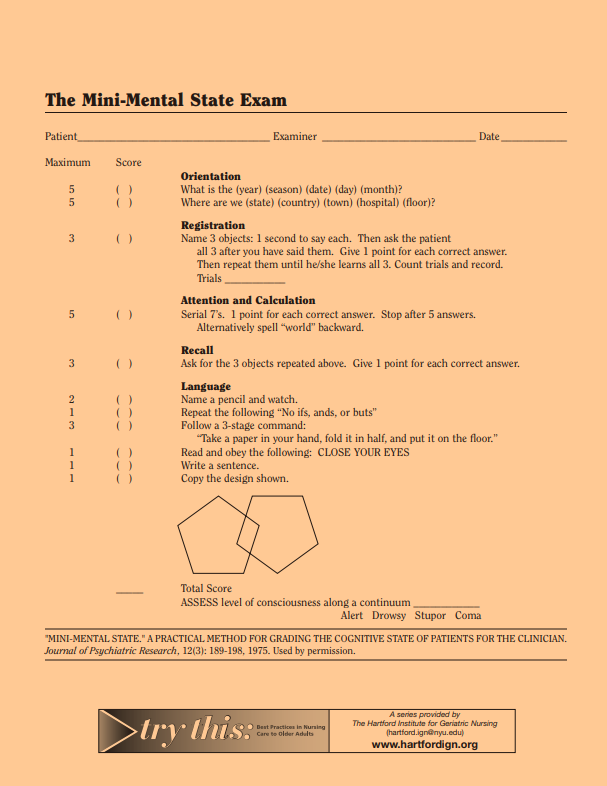
- Instead of using sum score and thresholds for diagnosis, let's use AI to evaluate the results!
## Preprocessing
- We need to preprocess diagnosis.csv and MMSE.csv
### Drop Unnecessary columns and NAs
#### MMSE.csv
- column names starting with MM refers to each tasks(Exclude MMLTR~s because they are duplicates)
- PTID and VISDATE is needed for merging with diagnosis data

In [23]:
import pandas as pd
mmse = pd.read_csv('mmse.csv')

# choose column names starting with MM but not MMLTR
mmse2 = mmse.filter(regex='^MM(?!LTR)', axis=1)

#tasks are mmse columns except MMSCORE
tasks = mmse2.columns[:-1].to_list()
print(tasks)

mmse2['VISDATE'] = mmse['VISDATE'].copy()
mmse2['PTID'] = mmse['PTID'].copy()

mmse2=mmse2.dropna(axis=0, how='any')

['MMDATE', 'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR', 'MMCITY', 'MMAREA', 'MMSTATE', 'MMTRIALS', 'MMD', 'MML', 'MMR', 'MMO', 'MMW', 'MMWATCH', 'MMPENCIL', 'MMREPEAT', 'MMHAND', 'MMFOLD', 'MMONFLR', 'MMREAD', 'MMWRITE', 'MMDRAW']


C:\Users\yeon0\AppData\Local\Temp\ipykernel_11800\1058792433.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmse2['VISDATE'] = mmse['VISDATE'].copy()
C:\Users\yeon0\AppData\Local\Temp\ipykernel_11800\1058792433.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmse2['PTID'] = mmse['PTID'].copy()


#### diagnosis.csv
- DIAGNOSIS is the target variable
- PTID and VISCODE is needed for merging with MMSE data

In [24]:
diagnosis = pd.read_csv('diagnosis.csv')
# diagnosis2 has only VISDATE, PTID, and DIAGNOSIS
diagnosis2 = diagnosis[['EXAMDATE','PTID','DIAGNOSIS']].copy()
diagnosis2['VISDATE'] = diagnosis2['EXAMDATE'].copy()
diagnosis2=diagnosis2.dropna(axis=0, how='any')

### Merge MMSE and diagnosis data on PTID and DATE

In [25]:

merged_df = pd.merge(mmse2, diagnosis2, on=['PTID','VISDATE'] , how='inner')
# subtract diagnosis by 1
merged_df['DIAGNOSIS'] = merged_df['DIAGNOSIS'] - 1

## EDA(Exploratory Data Analysis)
- We will inspect MMSE scores for each diagnosis and see if there is any pattern

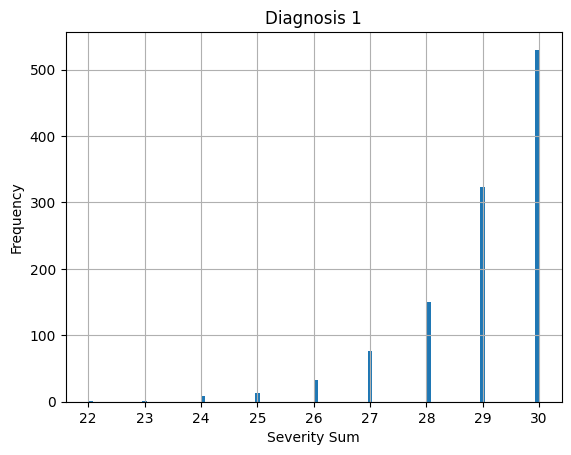

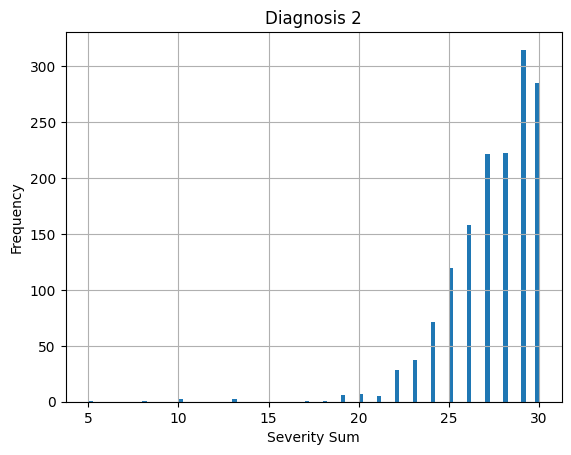

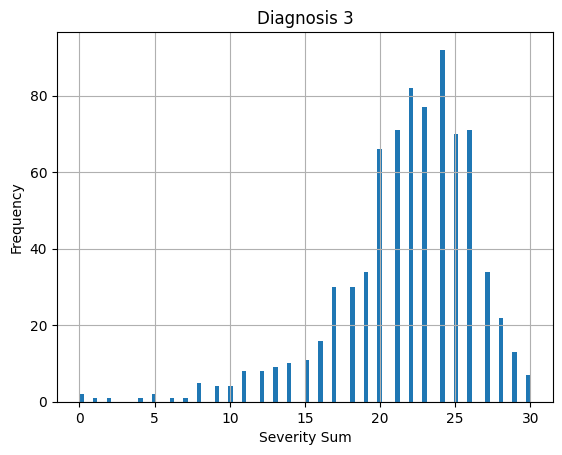

In [26]:
import matplotlib.pyplot as plt
# sevsum distribution for each diagnosis
for i in range(3):
    #distribution graph
    merged_df[merged_df['DIAGNOSIS']==i]['MMSCORE'].hist(bins=100)
    plt.xlabel('Severity Sum')
    plt.ylabel('Frequency')
    plt.title('Diagnosis '+str(i+1))
    plt.show()


Two interesting points:
1. We cannot diagnose dementia with MMSE score alone. 
   - Even Dementia patients can have max score of 30, but with low probability.
   - The average score seems to be CN > MCI > Dementia
2. Each distribution seems to be normal distribution which is 'capped' at 30.
   - MMSE wasn't hard enough discriminate smart people
   - All people who 'outsmarted' MMSE got same 30 points
=> We can find the probability of each diagnosis given MMSE score using Bayesian inference
## Modeling
- We will find the normal distribution parameters for each diagnosis (mean and std)
- Then we will use the parameters to calculate the probability of each diagnosis given MMSE score
- P(Diagnosis∣MMSE)= P(MMSE∣Diagnosis)⋅P(Diagnosis)/P(MMSE)
​


In [37]:
from scipy.optimize import minimize
import numpy as np

from scipy.stats import norm



def log_likelihood_censored(params, data, lower=0, upper=30):
    mean, std = params
    
    # Normal PDF for values strictly between 0 and 30
    likelihoods = norm.pdf(data, loc=mean, scale=std)
    
    # CDF for values censored at 0
    censored_lower = norm.cdf(lower, loc=mean, scale=std)
    
    # Survival function for values censored at 30
    censored_upper = 1 - norm.cdf(upper, loc=mean, scale=std)
    
    # Apply the correct likelihood adjustments for censored data
    likelihoods[data == lower] += censored_lower  # For scores of 0
    likelihoods[data == upper] += censored_upper  # For scores of 30
    
    # Return the negative log-likelihood (for minimization)
    return -np.sum(np.log(np.clip(likelihoods, 1e-10, None)))  # Avoid log of 0 with clipping



# Retry fitting the truncated normal distribution for each diagnosis group
corrected_params = {}

for diagnosis in sorted(merged_df['DIAGNOSIS'].unique()):
    diagnosis_group_data = merged_df[merged_df['DIAGNOSIS'] == diagnosis]['MMSCORE']
    
    # Initial guess for mean and std
    initial_params = [np.mean(diagnosis_group_data), np.std(diagnosis_group_data)]
    
    # Minimize negative log-likelihood to estimate parameters
    result = minimize(log_likelihood_censored, initial_params, args=(diagnosis_group_data,))
    corrected_params[diagnosis] = {'mean': result.x[0], 'std': result.x[1]}

# Display the corrected parameters accounting for the cutoff at 30
corrected_params


{0.0: {'mean': 29.313237989799358, 'std': 1.6111973590892144},
 1.0: {'mean': 27.595461549393217, 'std': 2.5503208781975277},
 2.0: {'mean': 21.74053538650768, 'std': 4.610040069741432}}

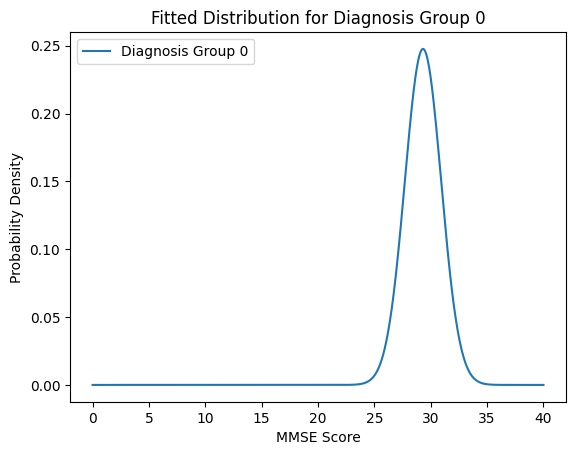

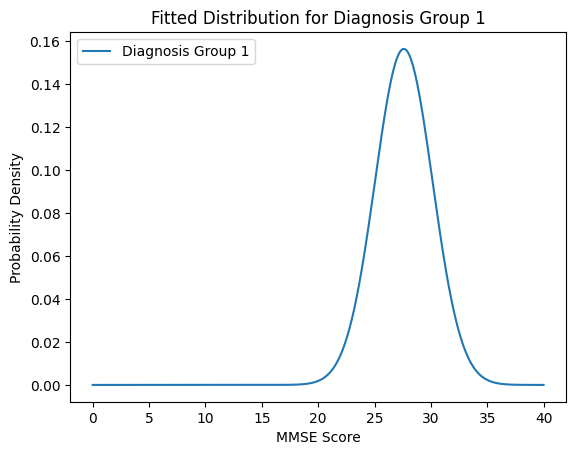

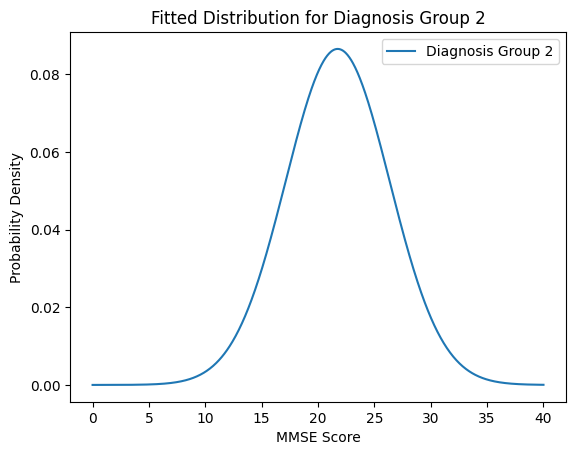

In [38]:
from scipy.stats import truncnorm
# Plot the fitted normal distributions for each diagnosis group without the cap at 30

x = np.linspace(0, 40, 1000)  # Define x values from 0 to 40 (since there is no cap anymore)

for diagnosis, params in corrected_params.items():
    mean, std = params['mean'], params['std']
    # Generate the corresponding normal distribution
    pdf = truncnorm.pdf(x, a=(0 - mean) / std, b=(40 - mean) / std, loc=mean, scale=std)
    
    # Plot the distribution
    plt.figure()
    plt.plot(x, pdf, label=f'Diagnosis Group {int(diagnosis)}')
    plt.title(f'Fitted Distribution for Diagnosis Group {int(diagnosis)}')
    plt.xlabel('MMSE Score')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()


In [57]:
# Update the function to consider scores of 30 or more
from scipy.stats import truncnorm
priors = {
    0.0: 0.68,  # CN
    1.0: 0.22,  # MCI
    2.0: 0.10   # Dementia
}
def calculate_posterior(score, priors, distributions, max_score, min_score=0):
    likelihoods = {}
    
    for diagnosis, params in distributions.items():
        mean, std = params['mean'], params['std']
            # Normal PDF for values strictly between 0 and 30
        likelihoods[diagnosis] = norm.pdf(score, loc=mean, scale=std)
        if score==30:
            likelihoods[diagnosis] += 1 - norm.cdf(max_score , loc=mean, scale=std)
        if score==0:
            likelihoods[diagnosis] += norm.cdf(min_score, loc=mean, scale=std)    
    marginal_likelihood = sum(likelihoods[d] * priors[d] for d in priors)
    # Calculate the posterior probabilities for each diagnosis group
    posteriors = {diagnosis: (likelihoods[diagnosis] * priors[diagnosis]) / marginal_likelihood for diagnosis in priors}
    
    return posteriors

# Example usage: Calculate the probabilities for an MMSE score of 30
score_example = 30
posterior_probabilities = calculate_posterior(score_example, priors, corrected_params, max_score=30)

posterior_probabilities


{0.0: 0.8534816621717727, 1.0: 0.13444256460373177, 2.0: 0.012075773224495608}